Deep Q-Network on Atari Breakout game using Custom CNN

# Reinforcement Learning with Stable Baselines3

## Setup
Install necessary dependencies.

In [7]:
# Update the package lists for upgrades and new package installations
!apt-get update && apt-get install swig cmake
# Update the package lists and then install required packages for video visualization
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb
# Install box2d-py, a 2D physics engine
!pip install box2d-py
# Install a specific version of stable-baselines3 with extra dependencies
!pip install "stable-baselines3[extra]>=2.0.0a4"


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

## Import Libraries

In [8]:
# Import necessary libraries and modules
import os
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import base64
from IPython import display as ipythondisplay

# Print the versions of gymnasium and stable_baselines3 for debugging purposes
print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

# Import utility functions for creating Atari environments and stacking frames
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack


gym.__version__='0.29.1'
stable_baselines3.__version__='2.4.0a10'


## Configure Environment

In [9]:
# Set up a fake display for rendering videos
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


## Callbacks and Directory Setup

In [ ]:
# Define a callback class for saving models at regular intervals during training
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval
        self.save_path = save_path

    def _on_step(self) -> bool:
        # Save the model every 'save_interval' steps
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')
        return True


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create directories to store logs and trained models
log_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/gym/"
models_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/models/"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)


## Define Custom Feature Extractor and Create DQN Model

In [ ]:
# Define a custom CNN feature extractor for processing observations from the environment
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # Define the convolutional layers
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_space.shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute the size of the output tensor after passing through the CNN
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        # Define the linear layers that follow the convolutional layers
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Process the observations through the CNN and linear layers
        return self.linear(self.cnn(observations))


#### Initial Atari Environment for 'Pong'

In [11]:
setting="BreakoutNoFrameskip-v4"

# Initialize the Atari environment with the game 'Breakout' and configurations
env = make_atari_env(setting, n_envs=4, seed=0)

# Stack 4 consecutive frames together to provide temporal information
env = VecFrameStack(env, n_stack=4)


#### Initial the DQN model using custon CNN feature extractor'

In [ ]:
# Initialize the DQN agent with specified parameters
model = DQN(
    env=env,
    policy='CnnPolicy',
    verbose=1,
    learning_rate=0.0001,
    buffer_size=10000,
    learning_starts=100000,
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    train_freq=4,
    batch_size=32,
    ######-----------ADD CUSTOM CNN TO SB3----------------------########
    # Uncomment the next line to use the custom CNN feature extractor
    policy_kwargs={'features_extractor_class': CustomCNN}
    ######------------------------------------------------------########
)


Using cuda device
Wrapping the env in a VecTransposeImage.


## Train the Model

In [ ]:
# Define the interval at which models are saved during training
save_interval = 20000
save_callback = SaveOnIntervalCallback(save_interval, models_dir)

# Train the DQN agent
model.learn(total_timesteps=1000000, callback=save_callback)

# Save the final model after training completes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
|    total_timesteps  | 869068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00216  |
|    n_updates        | 48066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93e+03 |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 465      |
|    time_elapsed     | 1866     |
|    total_timesteps  | 869300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00175  |
|    n_updates        | 48081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93e+03 |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|   

In [ ]:
final_model_path = os.path.join(models_dir, f'model_{1000000}')
model.save(final_model_path)

## Video Recording and Display Functions

In [ ]:
# Functions to record videos of the agent playing and display the videos

def show_videos(video_path="", prefix=""):
    """Displays videos from a specified directory."""
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{0}" autoplay
                      loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
            </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_video(env_id, model, video_length=500, prefix="", video_folder="/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/"):
    eval_env = make_atari_env(env_id, n_envs=1, seed=0, vec_env_cls=DummyVecEnv)  # Create a single Atari environment
    eval_env = VecFrameStack(eval_env, n_stack=4)  # Stack 4 frames together for temporal information
    eval_env = VecVideoRecorder(  # Initialize video recorder
        eval_env,
        video_folder=video_folder,  # Specify folder to save videos
        record_video_trigger=lambda step: step == 0,  # Set trigger to start recording at step 0
        video_length=video_length,  # Set video length
        name_prefix=prefix,  # Set prefix for video filenames
    )
    obs = eval_env.reset()  # Reset the environment to get initial observation
    for _ in range(video_length):  # Loop through for the specified video length
        action, _ = model.predict(obs)  # Predict action based on current observation
        obs, _, _, _ = eval_env.step(action)  # Execute action in the environment
    eval_env.close()  # Close the environment and video recorder




## Record and Display Videos at Different Training Stages

In [ ]:
# Create a directory to save videos
os.makedirs("videos", exist_ok=True)

# Record a video of the trained agent
record_video(setting, model, video_length=1000, prefix='dqn-wall')

# Display the video
import os

def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)
    model_files = [f for f in files if f.startswith('model_')]
    identifiers = [f.split('_')[1] for f in model_files]
    return identifiers

def find_key_identifiers(identifiers):
    identifiers.sort()  # Ensure identifiers are sorted
    earliest = identifiers[0]
    final = identifiers[-1]
    middle = identifiers[len(identifiers) // 2]
    return earliest, middle, final

def view(models_dir):
    identifiers = get_model_identifiers(models_dir)
    earliest, middle, final = find_key_identifiers(identifiers)

    # Record videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')
        model = DQN.load(model_path)
        record_video(setting, model, video_length=1000, prefix=f'dqn-wall-{stage}')

    # Display the videos
    for stage in ["beginning", "middle", "end"]:
        show_videos("videos", prefix=f'dqn-wall-{stage}')

# Changes the model directory below
models_dir="/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/models/"
view(models_dir)

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-step-0-to-step-1000.mp4


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-step-0-to-step-1000.mp4


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-beginning-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-beginning-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-beginning-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-beginning-step-0-to-step-1000.mp4
Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-middle-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-middle-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-middle-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-middle-step-0-to-step-1000.mp4
Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-end-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-end-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-end-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/videos/dqn-wall-end-step-0-to-step-1000.mp4


In [ ]:
for stage in ["beginning", "middle", "end"]:
    show_videos("videos", prefix=f'dqn-wall-{stage}')

# Policy gradient method

In [ ]:
# Create directories to store logs and trained models
log_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/gym"
models_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/models"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Add the import statement to bring in the PPO class
from stable_baselines3 import PPO

# Initialize the PPO agent with specified parameters
model = PPO(
    env=env,
    policy='CnnPolicy',
    verbose=1,
    clip_range=0.1,
    ent_coef=0.01,
    learning_rate=2.5e-4,
    n_epochs=4,
    n_steps=128,
    vf_coef=0.5,
    batch_size=256,
    ######-----------ADD CUSTOM CNN TO SB3----------------------########
    # Uncomment the next line to use the custom CNN feature extractor
    policy_kwargs={'features_extractor_class': CustomCNN},
    ######------------------------------------------------------########
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Define the interval at which models are saved during training
save_interval = 1000000//5
save_callback = SaveOnIntervalCallback(save_interval, models_dir)

# Train the PPO model
model.learn(total_timesteps=1000000, callback=save_callback)

Streaming output truncated to the last 5000 lines.
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.29e+03     |
|    ep_rew_mean          | 17.8         |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 1717         |
|    time_elapsed         | 2063         |
|    total_timesteps      | 879104       |
| train/                  |              |
|    approx_kl            | 0.0099493945 |
|    clip_fraction        | 0.0957       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.534       |
|    explained_variance   | 0.749        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.00873      |
|    n_updates            | 6892         |
|    policy_gradient_loss | -0.0105      |
|    value_loss           | 0.0816       |
------------------------------------------
---

In [ ]:
# Save the final model after training completes
final_model_path = os.path.join(models_dir, f'model_final')
model.save(final_model_path)

In [ ]:
# Functions to record videos of the agent playing and display the videos
def show_videos(video_path="", prefix=""):
    """Displays videos from a specified directory."""
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{0}" autoplay
                      loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
            </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def record_video(env_id, model, video_length=500, prefix="", video_folder="/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/"):
    eval_env = make_atari_env(env_id, n_envs=1, seed=0, vec_env_cls=DummyVecEnv)  # Create a single Atari environment
    eval_env = VecFrameStack(eval_env, n_stack=4)  # Stack 4 frames together for temporal information
    eval_env = VecVideoRecorder(  # Initialize video recorder
        eval_env,
        video_folder=video_folder,  # Specify folder to save videos
        record_video_trigger=lambda step: step == 0,  # Set trigger to start recording at step 0
        video_length=video_length,  # Set video length
        name_prefix=prefix,  # Set prefix for video filenames
    )
    obs = eval_env.reset()  # Reset the environment to get initial observation
    for _ in range(video_length):  # Loop through for the specified video length
        action, _ = model.predict(obs)  # Predict action based on current observation
        obs, _, _, _ = eval_env.step(action)  # Execute action in the environment
    eval_env.close()  # Close the environment and video recorder

In [ ]:
# Create a directory to save videos
os.makedirs("videos", exist_ok=True)

# Record a video of the trained agent
record_video(setting, model, video_length=1000, prefix='ppo-wall')

# Display the video
import os

def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)
    model_files = [f for f in files if f.startswith('model_')]
    identifiers = [f.split('_')[1] for f in model_files]
    return identifiers

def find_key_identifiers(identifiers):
    identifiers.sort()  # Ensure identifiers are sorted
    earliest = identifiers[0]
    final = identifiers[-1]
    middle = identifiers[len(identifiers) // 2]
    return earliest, middle, final

def view(models_dir):
    identifiers = get_model_identifiers(models_dir)
    earliest, middle, final = find_key_identifiers(identifiers)

    # Record videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')
        model = PPO.load(model_path)
        record_video(setting, model, video_length=1000, prefix=f'ppo-wall-{stage}')

    # Display the videos
    for stage in ["beginning", "middle", "end"]:
        show_videos("/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/", prefix=f'ppo-wall-{stage}')

# Changes the model directory below
models_dir="/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/models"
view(models_dir)

Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-step-0-to-step-1000.mp4
Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-beginning-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-beginning-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-beginning-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-beginning-step-0-to-step-1000.mp4
Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-middle-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-middle-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-middle-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-middle-step-0-to-step-1000.mp4
Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-end-step-0-to-step-1000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-end-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-end-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/videos/ppo-wall-end-step-0-to-step-1000.mp4


# TESTING SAVED MODELS AND PERFORMANCE COMPARISON

In [ ]:
from stable_baselines3 import PPO, DQN
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np

# Load the trained models
dqn_model = DQN.load('/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/models/model_1000000')
ppo_model = PPO.load('/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/models/model_final')

# Define and wrap the Breakout environment to preprocess observations
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")  # Initialize Atari environment
env = AtariPreprocessing(env, scale_obs=True)  # Preprocessing: grayscale, resize to 84x84, and normalize
env = FrameStack(env, num_stack=4)  # Stack the last 4 frames

# Reset the environment and get the initial observation
obs, info = env.reset()
obs = np.array(obs)  # Convert LazyFrames to NumPy array
print("Initial observation from env.reset():", obs.shape)

# Test model prediction with PPO model
action, _ = ppo_model.predict(obs)
print("PPO Model prediction (action):", action)

# Test model prediction with DQN model
action, _ = dqn_model.predict(obs)
print("DQN Model prediction (action):", action)

# Test a random action for comparison
random_action = env.action_space.sample()
print("Random action:", random_action)

# Take a step in the environment using the PPO model's action
obs, reward, done, truncated, info = env.step(action)
obs = np.array(obs)  # Convert LazyFrames to NumPy array
print("Observation after step:", obs.shape)
print("Reward after step:", reward)
print("Done flag after step:", done)
print("Truncated flag after step:", truncated)
print("Info after step:", info)


Initial observation from env.reset(): (4, 84, 84)
PPO Model prediction (action): 1
DQN Model prediction (action): 3
Random action: 1
Observation after step: (4, 84, 84)
Reward after step: 0.0
Done flag after step: False
Truncated flag after step: False
Info after step: {'lives': 5, 'episode_frame_number': 32, 'frame_number': 32}


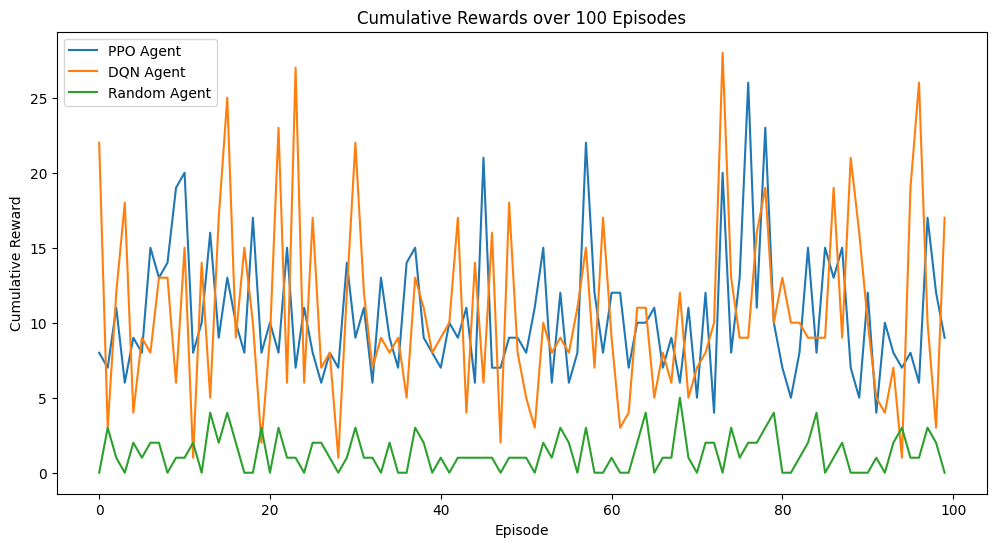

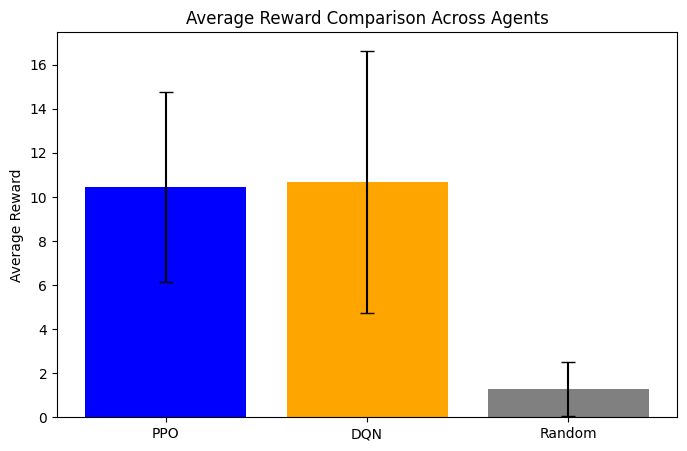

In [13]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from gymnasium.wrappers import FrameStack, GrayScaleObservation, ResizeObservation
import numpy as np
import matplotlib.pyplot as plt

# Load the trained models
dqn_model = DQN.load('/content/drive/MyDrive/43008 Reinforcement Learning/Week9/DQN/models/model_1000000')
ppo_model = PPO.load('/content/drive/MyDrive/43008 Reinforcement Learning/Week10/train6/models/model_final')

# Define and wrap the Breakout environment with preprocessing
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
env = ResizeObservation(env, 84)  # Resize frames to 84x84
env = GrayScaleObservation(env, keep_dim=False)  # Convert to grayscale
env = FrameStack(env, num_stack=4)  # Stack 4 frames

# Function to run an agent in the environment for a given number of episodes
def run_agent(env, agent, num_episodes=100):
    rewards = []
    for episode in range(num_episodes):
        obs, info = env.reset()
        obs = np.array(obs)
        episode_reward = 0
        done, truncated = False, False
        while not done and not truncated:
            if agent:
                action, _ = agent.predict(obs)  # Use model's prediction
            else:
                action = env.action_space.sample()  # Random action for the random agent

            obs, reward, done, truncated, info = env.step(action)
            obs = np.array(obs)
            episode_reward += reward
        rewards.append(episode_reward)
    return rewards

# Run simulations for each agent
num_episodes = 100
ppo_rewards = run_agent(env, ppo_model, num_episodes=num_episodes)
dqn_rewards = run_agent(env, dqn_model, num_episodes=num_episodes)
random_rewards = run_agent(env, None, num_episodes=num_episodes)

# Calculate metrics
agents = ["PPO", "DQN", "Random"]
avg_rewards = [np.mean(ppo_rewards), np.mean(dqn_rewards), np.mean(random_rewards)]
std_rewards = [np.std(ppo_rewards), np.std(dqn_rewards), np.std(random_rewards)]

# Plotting cumulative rewards for each agent
plt.figure(figsize=(12, 6))
plt.plot(ppo_rewards, label="PPO Agent")
plt.plot(dqn_rewards, label="DQN Agent")
plt.plot(random_rewards, label="Random Agent")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over 100 Episodes")
plt.legend()
plt.show()

# Bar plot for average reward with standard deviation
plt.figure(figsize=(8, 5))
plt.bar(agents, avg_rewards, yerr=std_rewards, capsize=5, color=["blue", "orange", "gray"])
plt.ylabel("Average Reward")
plt.title("Average Reward Comparison Across Agents")
plt.show()


In [14]:
print (random_rewards)
print (dqn_rewards)
print (ppo_rewards)

[0.0, 3.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 0.0, 4.0, 2.0, 4.0, 2.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 3.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 3.0, 2.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 4.0, 0.0, 1.0, 1.0, 5.0, 1.0, 0.0, 2.0, 2.0, 0.0, 3.0, 1.0, 2.0, 2.0, 3.0, 4.0, 0.0, 0.0, 1.0, 2.0, 4.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 3.0, 1.0, 1.0, 3.0, 2.0, 0.0]
[22.0, 3.0, 12.0, 18.0, 4.0, 9.0, 8.0, 13.0, 13.0, 6.0, 15.0, 1.0, 14.0, 5.0, 17.0, 25.0, 9.0, 15.0, 10.0, 2.0, 9.0, 23.0, 6.0, 27.0, 6.0, 17.0, 7.0, 8.0, 1.0, 12.0, 22.0, 12.0, 7.0, 9.0, 8.0, 9.0, 5.0, 13.0, 11.0, 8.0, 9.0, 10.0, 17.0, 4.0, 14.0, 6.0, 16.0, 2.0, 18.0, 8.0, 5.0, 3.0, 10.0, 8.0, 9.0, 8.0, 11.0, 15.0, 7.0, 17.0, 9.0, 3.0, 4.0, 11.0, 11.0, 5.0, 8.0, 6.0, 12.0, 5.0, 7.0, 8.0, 10.0, 28.0, 13.0, 9.0, 9.0, 16.0, 19.0, 10.0, 13.0, 10.0, 10.0, 9.0, 9.0, 9.0, 19.0, 9.0, 21.0, 16.0, 10.0,

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
